In [36]:
# 复现GCN
# 2022.08.17

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import os
project_path = os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

import imageio
from celluloid import Camera
from IPython.display import HTML # 如果要在jupyter中显示，需要加入HTML
plt.rcParams['animation.ffmpeg_path'] = r'D:/Anaconda3/Lib/site-packages/ffmpeg-5.1-essentials_build/bin/ffmpeg.exe'

# GCN-1

In [38]:
# referece github links:https://github.com/dsgiitr/graph_nets/blob/master/GCN/GCN.py

## Convolutional layer

In [39]:
# 搭建graph convolution layer
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv,self).__init__()
        self.A_hat = A + torch.eye(A.size(0))  # 构造A_hat邻接矩阵
        self.D     = torch.diag(torch.sum(self.A_hat,1)) # torch.sum(A,dim=1)纵向求和；torch.diag构建度矩阵
        self.D_hat = self.D.inverse().sqrt() # inverse获取方阵的逆；sqrt()获取tensor的平方根
        self.A_hat = torch.mm(torch.mm(self.D_hat,self.A_hat),self.D_hat)
        self.W     = nn.Parameter(torch.rand(in_channels, out_channels), requires_grad=True) # 初始化参数矩阵。
                                            # rand(size)随机抽取[0,1)之间的数据组成size的tensor；nn.Parameter将不可训练tensor变成可训练tensor
    # 定义forward函数
    def forward(self, X):
        out = torch.relu(torch.mm(torch.mm(self.A_hat,X),self.W))
        return out

## Net layer

In [40]:
class Net(torch.nn.Module):
    def __init__(self,A,nfeat,nhid,nout):
        super(Net,self).__init__()
        self.conv1 = GCNConv(A,nfeat,nhid)
        self.conv2 = GCNConv(A,nhid,nout)
    
    def forward(self, X):
        H1 = self.conv1(X)
        H2 = self.conv2(H1)
        return H2

## data

In [41]:
# 'A' is the adjacency matrix, it contains 1 at a position (i,j)
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])

In [42]:
# label for admin(node 1) and instructor(node 34) so only these two contain the class label(0 and 1)
# all other are set to -1, meaning predicted value of these nodes is ignored in the loss function.
target=torch.tensor([0,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,1])

In [43]:
# X is the feature matrix.
# Using the one-hot encoding corresponding to the index of the node.
X=torch.eye(A.size(0))

In [44]:
X.size(0)

34

In [45]:
# Network with 10 features in the hidden layer and 2 in output layer.
T=Net(A,X.size(0), 10, 2)

## Training

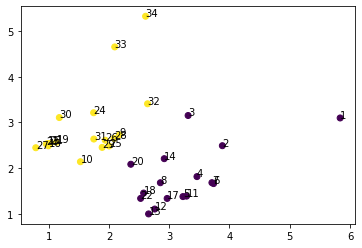

In [46]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1) # 定义损失函数评价指标
optimizer = optim.SGD(T.parameters(), lr=0.01, momentum=0.9)  # 更新权重w针对的是整个神经网络Net，而不是单层卷积Conv

loss=criterion(T(X),target)

# plot animation with celluloid
fig = plt.figure()
camera = Camera(fig)

for i in range(200):  # 迭代200次
    optimizer.zero_grad()  # 重置梯度为0。梯度就是导数，就是误差error
    loss=criterion(T(X), target) # 计算loss函数
    loss.backward()  # BP反向传播，计算梯度误差。
    optimizer.step()  # 更新权重，即权重参数w
    l = (T(X));
    
    plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=[0, 0, 0, 0 ,0 ,0 ,0, 0, 1, 1, 0 ,0, 0, 0, 1 ,1 ,0 ,0 ,1, 0, 1, 0 ,1 ,1, 1, 1, 1 ,1 ,1, 1, 1, 1, 1, 1 ])
    for i in range(l.shape[0]):
        text_plot = plt.text(l[i,0], l[i,1], str(i+1))
    
    camera.snap()

    if i%20==0:
        print("Cross Entropy Loss: =", loss.item())

animation = camera.animate(blit=False, interval=150)
animation.save('./train_karate_animation.mp4', writer='ffmpeg', fps=60)
HTML(animation.to_html5_video())